In [2]:
import numpy as np

#from assets.keras.keras.datasets import shapes_3d
from assets.keras.keras.preprocessing.image import ImageDataGenerator
from assets.keras.keras.models import Sequential
from assets.keras.keras.layers.core import Dense, Dropout, Activation, Flatten
from assets.keras.keras.layers.convolutional import Convolution3D, MaxPooling3D, ZeroPadding3D
from assets.keras.keras.layers.normalization import BatchNormalization
from assets.keras.keras.optimizers import SGD, RMSprop, Adam
from assets.keras.keras.utils import np_utils, generic_utils
from assets.keras.keras.regularizers import l2
import theano
import matplotlib.pyplot as plt
import math
from assets.vis_utils import *
%matplotlib nbagg
%load_ext autoreload
%autoreload 2

#load dataset from gen_dataset
import cPickle as pickle

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [15]:
from assets.gen_motion import gen_dataset
import math
#gen_dataset(size, N, obj_type, obj_theta, obj_vel, types, velocity, theta, coherence, dots, directions(opt))
X_train,Y_train,X_test,Y_test = gen_dataset((16,32,32),100,None,['translate'],[1],[0,math.pi],[1],[150],[0])

n = X_train.shape[0]
tr_f = np.rint(n*0.9).astype('uint32')

X_val = X_train[tr_f:,:,:,:,:]
Y_val = Y_train[tr_f:,:]
X_train = X_train[:tr_f,:,:,:,:]
Y_train = Y_train[:tr_f,:]

print 'Train data shape: ', X_train.shape
print 'Train labels shape: ', Y_train.shape
print 'Test data shape: ', X_test.shape
print 'Test labels shape: ', Y_test.shape

###

print(X_train.shape[0], 'train samples')
print(X_val.shape[0], 'val samples')
print(X_test.shape[0], 'test samples')

Y_train/=math.pi
Y_val/=math.pi
Y_test/=math.pi
Y_train = np_utils.to_categorical(Y_train[:,2]-1, 2)
Y_val = np_utils.to_categorical(Y_val[:,2]-1,2)
Y_test = np_utils.to_categorical(Y_test[:,2]-1, 2)

Train data shape:  (162, 1, 16, 32, 32)
Train labels shape:  (162, 6)
Test data shape:  (20, 1, 16, 32, 32)
Test labels shape:  (20, 6)
(162, 'train samples')
(18, 'val samples')
(20, 'test samples')


<IPython.core.display.Javascript object>


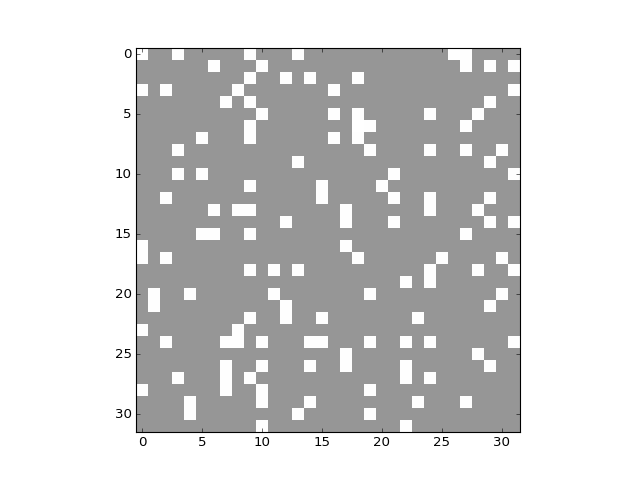

In [16]:
visualize_matrix(X_train[0,0,:,:,:],interval_len=50)

In [17]:

#(X_train, Y_train),(X_test, Y_test) = shapes_3d.load_data(test_split=test_split,
#                                                          dataset_size=dataset_size,
#                                                          patch_size=patch_size)

print('X_train shape:', X_train.shape)
print('Y_train shape:', Y_train.shape)
print('X_test shape:', X_test.shape)
print('Y_test shape:', Y_test.shape)
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')



('X_train shape:', (162, 1, 16, 32, 32))
('Y_train shape:', (162, 2))
('X_test shape:', (20, 1, 16, 32, 32))
('Y_test shape:', (20, 2))
(162, 'train samples')
(20, 'test samples')


In [19]:
def build_eval(r,l,nb_f,nb_p,nb_c,data):
    batch_size = 20
    nb_classes = 2
    nb_epoch = 10
    X_train,Y_train,X_val,Y_val,X_test,Y_test = data
    model = Sequential()
    model.add(ZeroPadding3D((1,1,1),input_shape=(1,16,32,32)))
    model.add(Convolution3D(nb_f[0],len_conv_dim1=nb_c[0], len_conv_dim2=nb_c[0], len_conv_dim3=nb_c[0], border_mode='valid',
                             activation='relu', W_regularizer=l2(r),dim_ordering='th'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(nb_p[0], nb_p[0], nb_p[0])))
    #model.add(Dropout(0.5))
    #model.add(ZeroPadding3D((1,1,1)))
    model.add(Convolution3D(nb_f[1],len_conv_dim1=nb_c[1], len_conv_dim2=nb_c[1], len_conv_dim3=nb_c[1], border_mode='valid',
                            activation='relu', W_regularizer=l2(r)))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(nb_p[1], nb_p[1], nb_p[1])))
    #model.add(Dropout(0.5))
    #model.add(ZeroPadding3D((1,1,1)))
    model.add(Convolution3D(nb_f[2],len_conv_dim1=nb_c[2], len_conv_dim2=nb_c[2], len_conv_dim3=nb_c[2], border_mode='valid',
                            activation='relu', W_regularizer=l2(r)))
    model.add(BatchNormalization())
    model.add(Flatten())
    #model.add(Dropout(0.5))
    #model.add(Dense(4, init='normal', activation='relu', W_regularizer=l2(reg)))
    model.add(Dense(nb_classes, init='normal', W_regularizer=l2(r)))
    model.add(Activation('softmax'))

    #Adam
    sgd = RMSprop(lr=l, decay=1e-6, momentum=0.9, nesterov=True)
    model.compile(loss='categorical_crossentropy', optimizer=sgd)

    hist = model.fit(X_train, Y_train, batch_size=batch_size, nb_epoch=nb_epoch, show_accuracy=False, verbose=0,
              validation_data=(X_val,Y_val))
    scoretr = model.evaluate(X_train, Y_train, batch_size=batch_size, show_accuracy=True)
    scoreva = model.evaluate(X_val, Y_val, batch_size=batch_size, show_accuracy=True)
    return (model, hist, scoretr, scoreva)

In [20]:
iters = 1

data = (X_train,Y_train,X_val,Y_val,X_test,Y_test)

best_model = None
best_val = 0
best_hist = None
best_scoretr = None
best_scoreva = None
best_params = None

for i in range(iters):
    # for each iteration
    print 'Training model #: ', i+1
    nb_filters = [2**np.random.randint(2,3),2**np.random.randint(2,3),2**np.random.randint(2,3)]
    nb_pool = [2,2]
    nb_conv = [3,3,3]
    reg = 10**(-1*np.random.rand()*2)
    l_r = 10**(-1*(np.random.rand()*2+4))
    model,hist,scoretr,scoreva = build_eval(reg,l_r,nb_filters,nb_pool,nb_conv,data)
    if scoreva[1] > best_val:
        best_model = model
        best_hist = hist
        best_scoretr = scoretr
        best_scoreva = scoreva
        best_val = scoreva[1]
        best_params = (reg,l_r,nb_filters,nb_pool,nb_conv)
    

Training model #:  1
18/18 [==============================] - 0s


In [22]:
scorete = best_model.evaluate(X_test, Y_test, batch_size=20, show_accuracy=True)

print('Train loss:', best_scoretr[0])
print('Train accuracy:', best_scoretr[1])
print('Val loss:', best_scoreva[0])
print('Val accuracy:', best_scoreva[1])
print('Test loss:', scorete[0])
print('Test accuracy:', scorete[1])

print best_params

20/20 [==============================] - 0s
('Train loss:', 0.69242132151568381)
('Train accuracy:', 0.55555555555555558)
('Val loss:', 0.69224321842193604)
('Val accuracy:', 0.55555555555555558)
('Test loss:', 0.69141650199890137)
('Test accuracy:', 0.59999999999999998)
(0.3604585163311396, 4.273987390296611e-05, [4, 4, 4], [2, 2], [3, 3, 3])


<IPython.core.display.Javascript object>


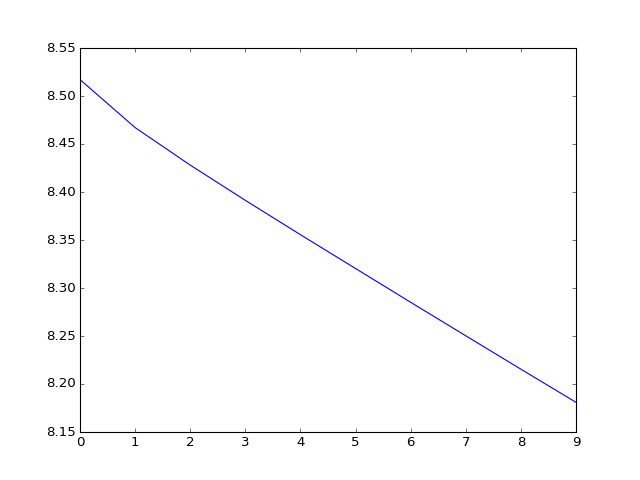

In [23]:
#print best_model.history.history.keys()
plt.plot(np.asarray(best_model.history.history['loss'])[0:500])

In [12]:
# (#outputs,#inputs,time,x-dir,y-dir)
for layer in model.layers:
    g = layer.get_config()
    h = layer.get_weights()
    #print g
    for hi in h:
        #print hi
        print hi.shape

(2, 1, 3, 3, 3)
(2,)
(2, 2, 3, 3, 3)
(2,)
(2, 2, 3, 3, 3)
(2,)
(2420, 4)
(4,)
(4, 2)
(2,)
